In [101]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys

sys.path.insert(0, str(Path.cwd().parent))

from cogwheel import data, gw_utils, gw_plotting, utils
from dot_pe import inference, waveform_banks, config
from dot_pe.zoom import zoom_iteration, zoom
from dot_pe.utils import load_intrinsic_samples_from_rundir
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior
from scipy.stats import multivariate_normal, norm
from matplotlib.lines import Line2D
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Zoom Iteration Demo

This notebook demonstrates the zoom iteration workflow: creating an injection, building an initial bank, running inference, and performing zoom iterations to improve sampling efficiency.


## Step 1: Create Injection

Create a high SNR injection with low luminosity distance for testing.


In [ ]:
# Event name
event_name = "zoom_example_event"

# Create injection directory
injection_dir = Path("injection")
injection_dir.mkdir(exist_ok=True)

# Create event data with Gaussian noise
event_data = data.EventData.gaussian_noise(
    eventname=event_name,
    detector_names="HL",
    duration=120.0,
    asd_funcs=["asd_H_O3", "asd_L_O3"],
    tgps=0.0,
    fmax=1600.0,
    seed=20250311,
)

# Create injection parameters (high SNR, low d_luminosity)
mchirp = 30.0
q = 0.5
m1, m2 = gw_utils.mchirpeta_to_m1m2(mchirp, gw_utils.q_to_eta(q))

injection_pars = dict(
    m1=m1,
    m2=m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.6,
    s2z=0.6,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=1.5e3,  # Low distance for high SNR
    t_geocenter=0.0,
)

# Inject signal
event_data.inject_signal(injection_pars, "IMRPhenomXPHM")

# Save injection
injection_path = injection_dir / f"{event_name}.npz"
event_data.to_npz(filename=injection_path, overwrite=True)
print(f"Injection saved to {injection_path}")

injection_lnlike = (
    event_data.injection["d_h"] - 1 / 2 * event_data.injection["h_h"]
).sum()
print(f"Injection SNR^2 = {2 * injection_lnlike:.3g}")
print(f"Injection SNR = {np.sqrt(2 * injection_lnlike):.3g}")

Injection saved to injection/zoom_example_event.npz
Injection SNR^2 = 274
Injection SNR = 16.6


## Step 2: Create Initial Bank

Create a wide prior bank with 2^16 samples for initial inference.


In [ ]:
# Bank parameters
bank_dir = Path("bank")
bank_size = 2**16  # 65536 samples
mchirp_min = 15.0
mchirp_max = 65.0
q_min = 0.2
f_ref = 50.0
fbin = config.DEFAULT_FBIN
approximant = "IMRPhenomXPHM"

# Create bank directory
bank_dir.mkdir(parents=True, exist_ok=True)
waveform_dir = bank_dir / "waveforms"
waveform_dir.mkdir(exist_ok=True)

# Generate samples from PowerLawIntrinsicIASPrior
print("Generating samples from PowerLawIntrinsicIASPrior...")
powerlaw_prior = PowerLawIntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)

powerlaw_samples = powerlaw_prior.generate_random_samples(
    bank_size, seed=1701, return_lnz=False
)
print(f"Generated {len(powerlaw_samples):,} samples")

# Add derived quantities
powerlaw_samples["mchirp"] = gw_utils.m1m2_to_mchirp(
    powerlaw_samples["m1"], powerlaw_samples["m2"]
)
powerlaw_samples["lnq"] = np.log(powerlaw_samples["m2"] / powerlaw_samples["m1"])
powerlaw_samples["chieff"] = gw_utils.chieff(
    *powerlaw_samples[["m1", "m2", "s1z", "s2z"]].values.T
)

# Calculate importance weights (IAS/PowerLaw ratio)
mchirp = powerlaw_samples["mchirp"].values
powerlaw_samples["log_prior_weights"] = 1.7 * np.log(mchirp)

# Save samples (only necessary columns)
columns_to_save = [
    "m1",
    "m2",
    "s1z",
    "s1x_n",
    "s1y_n",
    "s2z",
    "s2x_n",
    "s2y_n",
    "iota",
    "log_prior_weights",
]
samples_path = bank_dir / "intrinsic_sample_bank.feather"
powerlaw_samples[columns_to_save].to_feather(samples_path)
print(f"Saved samples to {samples_path}")

# Create bank configuration
bank_config = {
    "bank_size": bank_size,
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": fbin.tolist(),
    "approximant": approximant,
    "seed": 1701,
}

bank_config_path = bank_dir / "bank_config.json"
with open(bank_config_path, "w") as f:
    json.dump(bank_config, f, indent=4)
print(f"Saved bank config to {bank_config_path}")

# Generate waveforms
print("Generating waveforms...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_config_path,
    waveform_dir=waveform_dir,
    n_pool=4,
    blocksize=4096,
    approximant=approximant,
)
print(f"Bank created at {bank_dir}")


Generating samples from PowerLawIntrinsicIASPrior...


2025-11-25 00:17:50,461 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:17:50 2025


Generated 65,536 samples
Saved samples to bank/intrinsic_sample_bank.feather
Saved bank config to bank/bank_config.json
Generating waveforms...


2025-11-25 00:18:16,067 - INFO - dot_pe.waveform_banks finished after 25.6 seconds (0.427 minutes).


Bank created at bank


## Step 3: Run Initial Inference

Run inference with the initial bank and display summary results.


In [7]:
# Load event data
event_data = data.EventData.from_npz(filename=injection_path)
event_dir = Path("inference_runs") / event_data.eventname
event_dir.mkdir(parents=True, exist_ok=True)

# Run inference
rundir = inference.run(
    event_dir=str(event_dir),
    event=event_data,
    bank_folder=str(bank_dir),
    n_int=bank_size,
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=1337,
    size_limit=10**6,
    draw_subset=True,
)

print(f"Inference complete. Results in {rundir}")

# Load and display summary results
summary_path = Path(rundir) / "summary_results.json"
summary = utils.read_json(summary_path)
print("\nSummary results:")
print(f"  n_effective: {summary['n_effective']:.2f}")
print(f"  n_effective_i: {summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary['n_effective_e']:.2f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 64/64 [02:19<00:00,  2.18s/it]


535 intrinsic samples selected.
Generating extrinsic samples...


2025-11-25 00:23:28 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:01<00:00,  9.11obj/s, batches=1/17, accepted=16/16]
2025-11-25 00:23:30 - MarginalizationInfo object created!
2025-11-25 00:23:30 - Saving MarginalizationInfo object to inference_runs/zoom_example_event/run_0.


Creating 1 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.0416 seconds.
Saving samples to file...
Samples saved to:
 inference_runs/zoom_example_event/run_0/samples.feather
Inference complete. Results in inference_runs/zoom_example_event/run_0

Summary results:
  n_effective: 569.64
  n_effective_i: 11.52
  n_effective_e: 189.56


## Step 4: First Zoom Iteration

Fit a Gaussian zoomer to the top-weighted samples, create a focused bank, and run inference.


In [14]:
# Load intrinsic samples from initial inference
post_samples = load_intrinsic_samples_from_rundir(rundir)
weights = post_samples["weights"].values

# Select top 0.9 weight samples
sorted_idx = np.argsort(weights)[::-1]
cumsum_weights = np.cumsum(weights[sorted_idx])
threshold = 0.9
n_selected = np.max([np.searchsorted(cumsum_weights, threshold) + 1, 20])
selected_idx = sorted_idx[:n_selected]
top_samples = post_samples.iloc[selected_idx]
top_weights = weights[selected_idx]

print(f"Selected {n_selected} samples (sum of weights: {top_weights.sum():.3f})")


Selected 20 samples (sum of weights: 0.925)


In [16]:
# Fit zoomer with n_sig=1
prior_kwargs = {
    "mchirp_range": (mchirp_min, mchirp_max),
    "q_min": q_min,
    "f_ref": f_ref,
}
zoomer, cond_sampler, bounds = zoom_iteration.fit_zoomer(
    top_samples, top_weights, prior_kwargs, seed=9731, n_sig=1
)

print(f"Zoomer mean: {zoomer.mean}")
print("Zoomer covariance matrix:")
print(zoomer.cov)


Zoomer mean: [30.83683047 -0.66658044  0.62074589]
Zoomer covariance matrix:
[[12.99783998  1.40786121  1.16351206]
 [ 1.40786121  0.54684778  0.19363681]
 [ 1.16351206  0.19363681  0.11939984]]


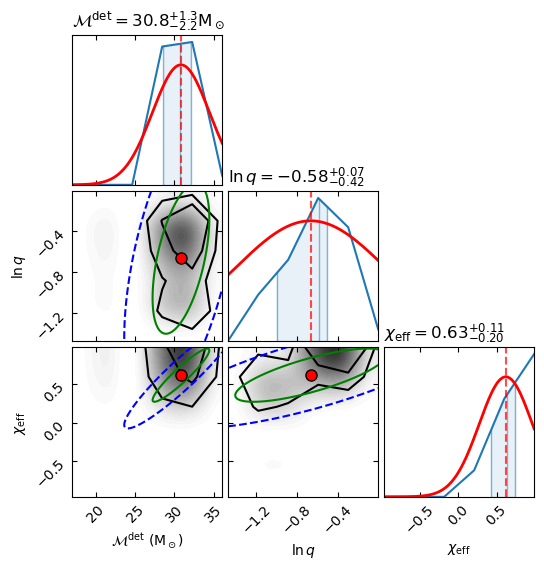

In [ ]:
# Create corner plot with Gaussian overlay
cp = gw_plotting.CornerPlot(post_samples, params=["mchirp", "lnq", "chieff"])
cp.plot()

# Overlay 1D Gaussians on diagonal axes
param_order = ["mchirp", "lnq", "chieff"]
for i, param in enumerate(param_order):
    ax = cp.axes[i, i]
    mean_1d = zoomer.mean[i]
    std_1d = np.sqrt(zoomer.cov[i, i])
    
    xlim = ax.get_xlim()
    x = np.linspace(xlim[0], xlim[1], 200)
    
    rv_1d = norm(mean_1d, std_1d)
    pdf_1d = rv_1d.pdf(x)
    
    # Normalize to match histogram scale
    ylim = ax.get_ylim()
    pdf_1d_scaled = pdf_1d * (ylim[1] - ylim[0]) / pdf_1d.max() * 0.8
    
    ax.plot(x, pdf_1d_scaled + ylim[0], "r-", linewidth=2, label="Fitted Gaussian")
    ax.axvline(mean_1d, color="red", linestyle="--", linewidth=1.5, alpha=0.7)

# Overlay 2D Gaussian contours and mean on off-diagonal axes
pairs = [
    (("mchirp", "lnq"), (0, 1)),
    (("mchirp", "chieff"), (0, 2)),
    (("lnq", "chieff"), (1, 2)),
]

for (p1, p2), (i1, i2) in pairs:
    ax = cp.axes[i2, i1]
    mean_2d = zoomer.mean[[i1, i2]]
    cov_2d = zoomer.cov[[i1, i2], :][:, [i1, i2]]
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    rv = multivariate_normal(mean_2d, cov_2d)
    Z = rv.pdf(pos)
    
    levels = [rv.pdf(mean_2d) * np.exp(-0.5 * v**2) for v in [2, 1]]
    
    ax.contour(X, Y, Z, levels=[levels[0]], colors=["blue"], linestyles=["--"], linewidths=1.5)
    ax.contour(X, Y, Z, levels=[levels[1]], colors=["green"], linestyles=["-"], linewidths=1.5)
    ax.plot(mean_2d[0], mean_2d[1], "ro", markersize=8, markeredgecolor="black", markeredgewidth=1)

plt.show()


In [18]:
# Create new bank using zoomer (small bank of 4096 samples)
zoom_iter1_dir = Path("zoom") / "iter1"
zoom_iter1_dir.mkdir(parents=True, exist_ok=True)

new_bank = zoom_iteration.draw_from_zoomer(
    zoomer, cond_sampler, bounds, n_samples=4096, seed=3141
)

# Save bank
bank_output_dir = zoom_iter1_dir / "bank"
bank_output_dir.mkdir(parents=True, exist_ok=True)
samples_path = bank_output_dir / "intrinsic_sample_bank.feather"
new_bank.to_feather(samples_path)

# Update bank config
bank_config = json.load(open(bank_dir / "bank_config.json"))
bank_config.update({"bank_size": len(new_bank)})
json.dump(bank_config, open(bank_output_dir / "bank_config.json", "w"), indent=2)

print(f"Created bank at {samples_path} ({len(new_bank)} samples)")

# Generate waveforms
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_output_dir / "bank_config.json",
    waveform_dir=bank_output_dir / "waveforms",
    n_pool=4,
    blocksize=4096,
    approximant="IMRPhenomXPHM",
)
print("Waveforms generated")


2025-11-25 00:29:37,074 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:29:37 2025
2025-11-25 00:29:37,074 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:29:37 2025


Created bank at zoom/iter1/bank/intrinsic_sample_bank.feather (4096 samples)


2025-11-25 00:29:46,753 - INFO - dot_pe.waveform_banks finished after 9.68 seconds (0.161 minutes).
2025-11-25 00:29:46,753 - INFO - dot_pe.waveform_banks finished after 9.68 seconds (0.161 minutes).


Waveforms generated


In [23]:
# Run inference with zoomed bank
# Use extrinsic samples from previous run with draw_subset=True, n_draws=1
extrinsic_samples_path = Path(rundir) / "extrinsic_samples.feather"

rundir_iter1 = inference.run(
    event_dir=str(zoom_iter1_dir),
    event=event_data,
    bank_folder=str(bank_output_dir),
    n_int=len(new_bank),
    n_ext=2048,  # Will use extrinsic_samples
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=1618,
    size_limit=10**6,
    draw_subset=True,
    n_draws=1,
    extrinsic_samples=str(extrinsic_samples_path),
)

print(f"Zoom iteration 1 inference complete. Results in {rundir_iter1}")

# Display results
summary_iter1 = utils.read_json(Path(rundir_iter1) / "summary_results.json")
print("\nZoom iteration 1 results:")
print(f"  n_effective: {summary_iter1['n_effective']:.2f}")
print(f"  n_effective_i: {summary_iter1['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary_iter1['n_effective_e']:.2f}")


Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


1537 intrinsic samples selected.
Loading extrinsic samples from file...
Creating 2 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 4/4 [00:26<00:00,  6.59s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.0117 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter1/run_1/samples.feather
Zoom iteration 1 inference complete. Results in zoom/iter1/run_1

Zoom iteration 1 results:
  n_effective: 2600.61
  n_effective_i: 15.28
  n_effective_e: 305.37


## Step 5: Efficiency Calculation

Calculate efficiency and extrapolate to 2^16 bank size.


In [24]:
# Calculate efficiency
n_effective_i_iter1 = summary_iter1["n_effective_i"]
bank_size_iter1 = len(new_bank)
efficiency = n_effective_i_iter1 / bank_size_iter1

print(f"Zoom iteration 1 efficiency: {efficiency:.4f}")
print(f"  n_effective_i: {n_effective_i_iter1:.2f}")
print(f"  bank_size: {bank_size_iter1}")

# Extrapolate to 2^16
extrapolated_n_effective = efficiency * 2**16
print(f"\nExtrapolated n_effective_i for 2^16 bank: {extrapolated_n_effective:.0f}")


Zoom iteration 1 efficiency: 0.0037
  n_effective_i: 15.28
  bank_size: 4096

Extrapolated n_effective_i for 2^16 bank: 244


## Step 6: Second Zoom Iteration

Fit a new zoomer from iteration 1 results, compare with iteration 1 zoomer, create a small bank, and run a small PE to check convergence.


In [25]:
# Load samples from first zoom iteration
post_samples_iter1 = load_intrinsic_samples_from_rundir(rundir_iter1)
weights_iter1 = post_samples_iter1["weights"].values

# Select top 0.9 weight samples
sorted_idx_iter1 = np.argsort(weights_iter1)[::-1]
cumsum_weights_iter1 = np.cumsum(weights_iter1[sorted_idx_iter1])
n_selected_iter1 = np.searchsorted(cumsum_weights_iter1, threshold) + 1
selected_idx_iter1 = sorted_idx_iter1[:n_selected_iter1]
top_samples_iter1 = post_samples_iter1.iloc[selected_idx_iter1]
top_weights_iter1 = weights_iter1[selected_idx_iter1]

print(f"Selected {n_selected_iter1} samples for iteration 2")

# Fit new zoomer
zoomer_iter2, cond_sampler_iter2, bounds_iter2 = zoom_iteration.fit_zoomer(
    top_samples_iter1, top_weights_iter1, prior_kwargs, seed=496351, n_sig=1
)

print(f"\nZoomer 1 mean: {zoomer.mean}")
print(f"Zoomer 2 mean: {zoomer_iter2.mean}")


Selected 97 samples for iteration 2

Zoomer 1 mean: [30.83683047 -0.66658044  0.62074589]
Zoomer 2 mean: [30.7790953  -0.75131758  0.62009637]


In [26]:
# Compare two Gaussians using Hellinger distance
# Sample from both Gaussians for comparison
xs_old, _ = zoomer.sample(1000, bounds=bounds)
xs_new, _ = zoomer_iter2.sample(1000, bounds=bounds)

hellinger = zoom_iteration.hellinger_distance(
    xs_old, xs_new, zoomer.distribution.logpdf, zoomer_iter2.distribution.logpdf
)

print(f"Hellinger distance between zoomer 1 and 2: {hellinger:.4f}")


Hellinger distance between zoomer 1 and 2: 0.3272


In [ ]:
# Create small bank (4096 samples) from zoomer-conditional-sampling
zoom_iter2_dir = Path("zoom") / "iter2"
zoom_iter2_dir.mkdir(parents=True, exist_ok=True)

print("Creating small bank (4096 samples) from zoomer...")
new_bank_iter2_small = zoom_iteration.draw_from_zoomer(
    zoomer_iter2, cond_sampler_iter2, bounds_iter2, n_samples=4096, seed=404
)

bank_output_dir_iter2 = zoom_iter2_dir / "bank"
bank_output_dir_iter2.mkdir(parents=True, exist_ok=True)
samples_path_iter2_small = bank_output_dir_iter2 / "intrinsic_sample_bank.feather"
new_bank_iter2_small.to_feather(samples_path_iter2_small)

# Create bank config
bank_config_iter2 = {
    "bank_size": len(new_bank_iter2_small),
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": fbin.tolist(),
    "approximant": approximant,
    "seed": 404,
}
bank_config_path_iter2 = bank_output_dir_iter2 / "bank_config.json"
json.dump(bank_config_iter2, open(bank_config_path_iter2, "w"), indent=2)
print(f"Created bank at {samples_path_iter2_small} ({len(new_bank_iter2_small)} samples)")

# Generate waveforms
print("Generating waveforms...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path_iter2_small,
    bank_config_path=bank_config_path_iter2,
    waveform_dir=bank_output_dir_iter2 / "waveforms",
    n_pool=4,
    blocksize=4096,
    approximant=approximant,
)
print("Waveforms generated")

# Run small PE to check convergence (n_draws=1)
extrinsic_samples_path_iter1 = Path(rundir_iter1) / "extrinsic_samples.feather"

rundir_iter2_small = inference.run(
    event_dir=str(zoom_iter2_dir),
    event=event_data,
    bank_folder=str(bank_output_dir_iter2),
    n_int=len(new_bank_iter2_small),
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=2001,
    size_limit=10**6,
    draw_subset=True,
    n_draws=1,
    extrinsic_samples=str(extrinsic_samples_path_iter1),
)

print(f"Zoom iteration 2 small PE complete. Results in {rundir_iter2_small}")

# Display results
summary_iter2_small = utils.read_json(Path(rundir_iter2_small) / "summary_results.json")
print("\nZoom iteration 2 small PE results:")
print(f"  n_effective: {summary_iter2_small['n_effective']:.2f}")
print(f"  n_effective_i: {summary_iter2_small['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary_iter2_small['n_effective_e']:.2f}")


Creating small bank (4096 samples) from zoomer...


2025-11-25 00:34:38,543 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:34:38 2025
2025-11-25 00:34:38,543 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:34:38 2025
2025-11-25 00:34:38,543 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:34:38 2025


Created bank at zoom/iter2/bank/intrinsic_sample_bank.feather (4096 samples)
Generating waveforms...


2025-11-25 00:34:47,607 - INFO - dot_pe.waveform_banks finished after 9.06 seconds (0.151 minutes).
2025-11-25 00:34:47,607 - INFO - dot_pe.waveform_banks finished after 9.06 seconds (0.151 minutes).
2025-11-25 00:34:47,607 - INFO - dot_pe.waveform_banks finished after 9.06 seconds (0.151 minutes).


Waveforms generated
Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


1349 intrinsic samples selected.
Loading extrinsic samples from file...
Creating 2 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 4/4 [00:24<00:00,  6.22s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 0.0118 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter2/run_0/samples.feather
Zoom iteration 2 small PE complete. Results in zoom/iter2/run_0

Zoom iteration 2 small PE results:
  n_effective: 4836.57
  n_effective_i: 18.62
  n_effective_e: 304.53
  Hellinger distance: 0.3272


## Step 7: Create Large Bank and Run Full PE

Create a large bank (2^16 samples) from iteration 2 zoomer and run full parameter estimation.


In [28]:
# Create large bank (2^16 samples) from zoomer-conditional-sampling
zoom_iter2_large_dir = Path("zoom") / "iter2_large"
zoom_iter2_large_dir.mkdir(parents=True, exist_ok=True)

print("Creating large bank (2^16 samples) from zoomer...")
new_bank_iter2_large = zoom_iteration.draw_from_zoomer(
    zoomer_iter2, cond_sampler_iter2, bounds_iter2, n_samples=2**16, seed=1984
)

bank_output_dir_iter2_large = zoom_iter2_large_dir / "bank"
bank_output_dir_iter2_large.mkdir(parents=True, exist_ok=True)
samples_path_iter2_large = bank_output_dir_iter2_large / "intrinsic_sample_bank.feather"
new_bank_iter2_large.to_feather(samples_path_iter2_large)

# Create bank config
bank_config_iter2_large = {
    "bank_size": len(new_bank_iter2_large),
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": fbin.tolist(),
    "approximant": approximant,
    "seed": 1984,
}
bank_config_path_iter2_large = bank_output_dir_iter2_large / "bank_config.json"
json.dump(bank_config_iter2_large, open(bank_config_path_iter2_large, "w"), indent=2)
print(f"Created bank at {samples_path_iter2_large} ({len(new_bank_iter2_large)} samples)")

# Generate waveforms
print("Generating waveforms...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path_iter2_large,
    bank_config_path=bank_config_path_iter2_large,
    waveform_dir=bank_output_dir_iter2_large / "waveforms",
    n_pool=4,
    blocksize=4096,
    approximant=approximant,
)
print("Waveforms generated")

# Run full PE with large bank
extrinsic_samples_path_iter2_small = Path(rundir_iter2_small) / "extrinsic_samples.feather"

rundir_iter2_large = inference.run(
    event_dir=str(zoom_iter2_large_dir),
    event=event_data,
    bank_folder=str(bank_output_dir_iter2_large),
    n_int=len(new_bank_iter2_large),
    n_ext=2048,
    n_phi=100,
    n_t=128,
    blocksize=1024,
    single_detector_blocksize=1024,
    seed=2049,
    size_limit=10**6,
    draw_subset=True,
)

print(f"Zoom iteration 2 large PE complete. Results in {rundir_iter2_large}")

# Display results
summary_iter2_large = utils.read_json(Path(rundir_iter2_large) / "summary_results.json")
print("\nZoom iteration 2 large PE results:")
print(f"  n_effective: {summary_iter2_large['n_effective']:.2f}")
print(f"  n_effective_i: {summary_iter2_large['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary_iter2_large['n_effective_e']:.2f}")


Creating large bank (2^16 samples) from zoomer...


2025-11-25 00:36:53,209 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:36:53 2025
2025-11-25 00:36:53,209 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:36:53 2025
2025-11-25 00:36:53,209 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:36:53 2025
2025-11-25 00:36:53,209 - INFO - dot_pe.waveform_banks started at Tue Nov 25 00:36:53 2025


Created bank at zoom/iter2_large/bank/intrinsic_sample_bank.feather (65536 samples)
Generating waveforms...


2025-11-25 00:37:18,440 - INFO - dot_pe.waveform_banks finished after 25.2 seconds (0.421 minutes).
2025-11-25 00:37:18,440 - INFO - dot_pe.waveform_banks finished after 25.2 seconds (0.421 minutes).
2025-11-25 00:37:18,440 - INFO - dot_pe.waveform_banks finished after 25.2 seconds (0.421 minutes).
2025-11-25 00:37:18,440 - INFO - dot_pe.waveform_banks finished after 25.2 seconds (0.421 minutes).


Waveforms generated
Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for zoom_example_event
Set intrinsic parameters, lnL = 134.28825617529495
Set time, lnL(L) = 93.47884683398746
Set sky location, lnL = 134.31729443752283
Set phase and distance, lnL = 134.31729443752283
Set mchirp_range = (np.float64(19.621972484853064), np.float64(114.09133258483041))


Processing intrinsic batches: 100%|██████████| 64/64 [02:15<00:00,  2.12s/it]


18631 intrinsic samples selected.
Generating extrinsic samples...


2025-11-25 00:39:56 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:01<00:00,  9.28obj/s, batches=1/583, accepted=16/16]
2025-11-25 00:39:58 - MarginalizationInfo object created!
2025-11-25 00:39:58 - Saving MarginalizationInfo object to zoom/iter2_large/run_0.


Creating 19 x 2 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 38/38 [02:39<00:00,  4.20s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 1.19 seconds.
Saving samples to file...
Samples saved to:
 zoom/iter2_large/run_0/samples.feather
Zoom iteration 2 large PE complete. Results in zoom/iter2_large/run_0

Zoom iteration 2 large PE results:
  n_effective: 46303.20
  n_effective_i: 240.23
  n_effective_e: 315.33


## Step 8: Compare Results

Compare intrinsic samples from the initial PE run with the final zoom iteration PE run.


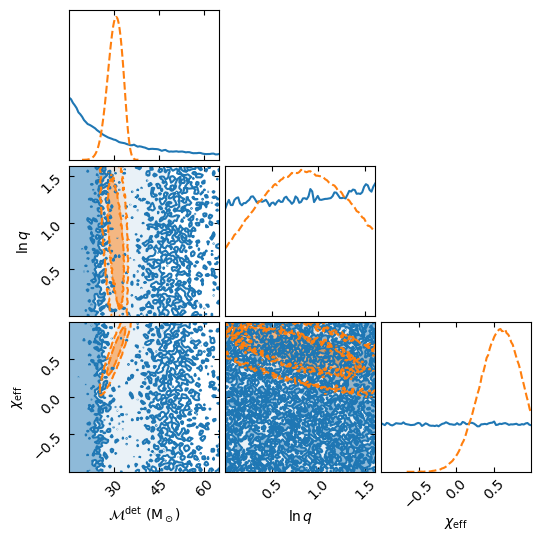

In [ ]:
# Compare banks

bank1 = pd.read_feather("bank/intrinsic_sample_bank.feather")
bank2 = pd.read_feather("zoom/iter2_large/bank/intrinsic_sample_bank.feather")

for b in [bank1, bank2]:
    b["mchirp"] = gw_utils.m1m2_to_mchirp(*b[["m1", "m2"]].values.T)
    b["lnq"] = np.log(np.divide(*b[["m1", "m2"]].values.T))
    b["chieff"] = gw_utils.chieff(*b[["m1", "m2", "s1z", "s2z"]].values.T)
    b["weights"] = np.exp(b["log_prior_weights"])
bank2["weights"] = np.exp(bank2["log_prior_weights"])
mcp = gw_plotting.MultiCornerPlot(
    [bank1, bank2],
    params=["mchirp", "lnq", "chieff"],
    weights_col="None",
)
mcp.plot()

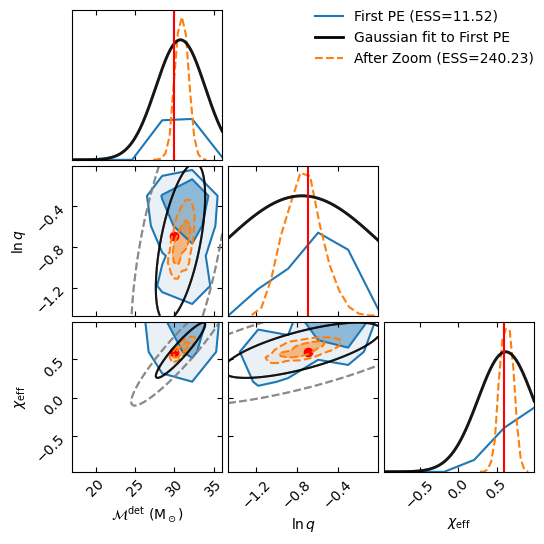

In [107]:
# Load intrinsic samples from both PE runs
samples_first = load_intrinsic_samples_from_rundir(rundir)
samples_after_zoom = load_intrinsic_samples_from_rundir(rundir_iter2_large)

# Load ESS values from summary results
summary_first = utils.read_json(Path(rundir) / "summary_results.json")
summary_after_zoom = utils.read_json(Path(rundir_iter2_large) / "summary_results.json")
ess_first = summary_first["n_effective_i"]
ess_after_zoom = summary_after_zoom["n_effective_i"]

# Create MultiCornerPlot comparing the two runs
mcp = gw_plotting.MultiCornerPlot(
    [samples_first, samples_after_zoom],
    params=["mchirp", "lnq", "chieff"],
    labels=[
        f"First PE (ESS={ess_first:.2f})",
        f"After Zoom (ESS={ess_after_zoom:.2f})",
    ],
)
mcp.plot(legend_title=f"Full mchirp range {mchirp_min}-{mchirp_max}")

# Overlay Gaussian from the last zoomer iteration (zoomer_iter2)
param_order = ["mchirp", "lnq", "chieff"]

# Overlay 1D Gaussians on diagonal axes
for i, param in enumerate(param_order):
    for cp in mcp.corner_plots:
        ax = cp.axes[i, i]
        mean_1d = zoomer_iter2.mean[i]
        std_1d = np.sqrt(zoomer_iter2.cov[i, i])

        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 200)

        rv_1d = norm(mean_1d, std_1d)
        pdf_1d = rv_1d.pdf(x)

        # Normalize to match histogram scale
        ylim = ax.get_ylim()
        pdf_1d_scaled = pdf_1d * (ylim[1] - ylim[0]) / pdf_1d.max() * 0.8

        ax.plot(x, pdf_1d_scaled + ylim[0], "k-", linewidth=2, alpha=0.7)

# Overlay 2D Gaussian contours and mean on off-diagonal axes
pairs = [
    (("mchirp", "lnq"), (0, 1)),
    (("mchirp", "chieff"), (0, 2)),
    (("lnq", "chieff"), (1, 2)),
]

for (p1, p2), (i1, i2) in pairs:
    for cp in mcp.corner_plots:
        ax = cp.axes[i2, i1]
        mean_2d = zoomer_iter2.mean[[i1, i2]]
        cov_2d = zoomer_iter2.cov[[i1, i2], :][:, [i1, i2]]

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        x = np.linspace(xlim[0], xlim[1], 200)
        y = np.linspace(ylim[0], ylim[1], 200)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))

        rv = multivariate_normal(mean_2d, cov_2d)
        Z = rv.pdf(pos)

        levels = [rv.pdf(mean_2d) * np.exp(-0.5 * v**2) for v in [2, 1]]

        ax.contour(
            X,
            Y,
            Z,
            levels=[levels[0]],
            colors=["gray"],
            linestyles=["--"],
            linewidths=1.5,
            alpha=0.7,
        )
        ax.contour(
            X,
            Y,
            Z,
            levels=[levels[1]],
            colors=["black"],
            linestyles=["-"],
            linewidths=1.5,
            alpha=0.7,
        )

# Add Gaussian fit curve to the legend
# Get handles and labels from the first corner plot
handles, labels = mcp.corner_plots[0].axes[0][0].get_legend_handles_labels()
# Create a proxy line for the Gaussian fit
gaussian_line = Line2D(
    [0],
    [0],
    color="black",
    linewidth=2,
    linestyle="-",
    label="Gaussian fit to First PE",
)
# Insert Gaussian fit between First PE and After Zoom (at index 1)
handles.insert(1, gaussian_line)
labels.insert(1, "Gaussian fit to First PE")
# Recreate the legend on the top-right axes with the updated handles and labels
mcp.corner_plots[0].axes[0][-1].legend(
    handles,
    labels,
    bbox_to_anchor=(1, 1),
    frameon=False,
    loc="upper right",
    borderaxespad=0,
    borderpad=0,
)
par_dic = event_data.injection["par_dic"]
mcp.scatter_points({"mchirp": 30, "lnq": np.log(0.5), "chieff": 0.6}, colors="r")
